### Some imports

In [89]:
import warnings
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [90]:
tsla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")

In [91]:
tsla_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## PART I

In [92]:
# Load Tesla stock data
tesla_data = tsla_df

# Ensure Date is the index
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

# Sort data by date
tesla_data.sort_index(inplace=True)

# Use 'Close' price for prediction
data = tesla_data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets (70% train, 30% test)
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data to fit LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [93]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.6577e-04 - val_loss: 0.0024
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.2197e-06 - val_loss: 0.0024
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.7074e-06 - val_loss: 0.0021
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.5341e-06 - val_loss: 0.0023
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.8699e-06 - val_loss: 0.0024
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3994e-06 - val_loss: 0.0025
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.0781e-06 - val_loss: 0.0018
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.5911e-06 - val_loss: 0.0029
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.5809e-06 - val_loss: 0.0018
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3545e-06 - val_loss: 0.0022


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 56.711105148432736


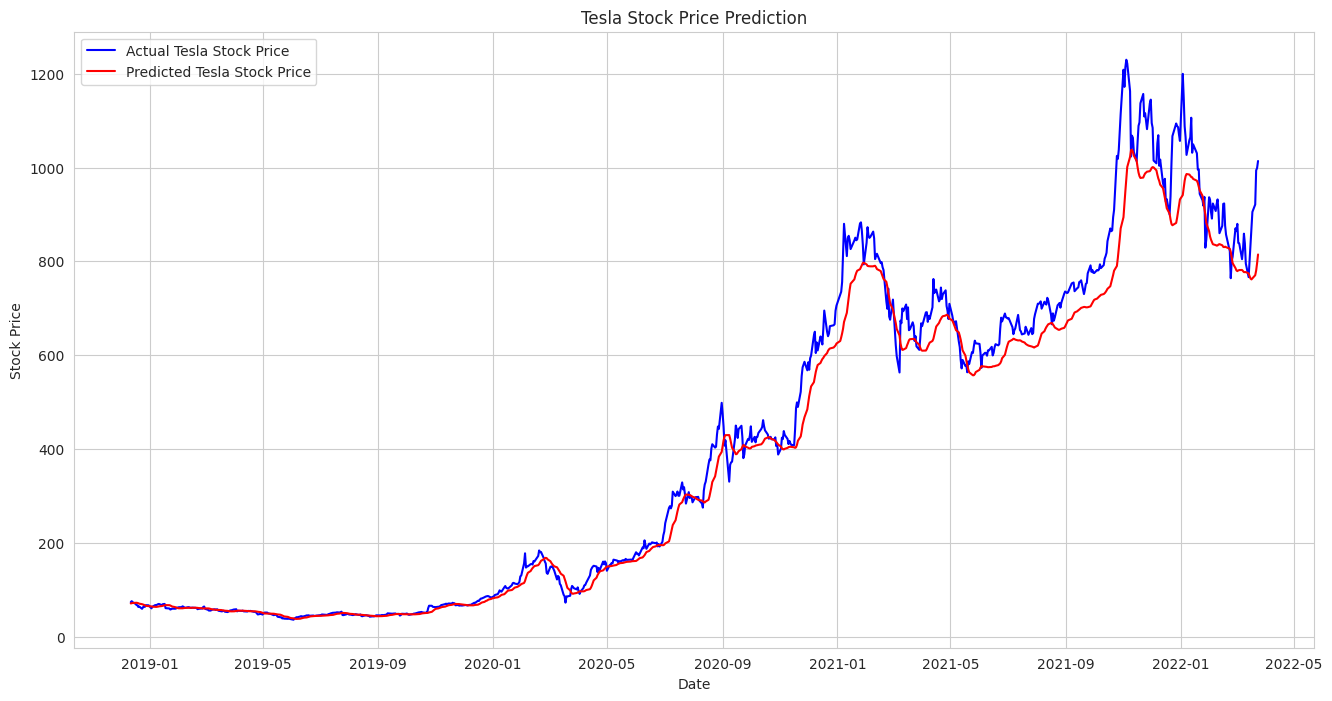

In [94]:
# Predict and inverse transform the scaled data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[train_size + seq_length:], y_test_inv, color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[train_size + seq_length:], predictions, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [97]:
# Load gold price data
gold_data = pd.read_csv('./docs/gold.csv')

gold_data['Date'] = pd.to_datetime(gold_data['Date'])

# # Ensure 'Date' is a column, not an index
# if tesla_data.index.name == 'Date':
#     tesla_data = tesla_data.reset_index()
# 
# if gold_data.index.name == 'Date':
#     gold_data = gold_data.reset_index()

# Merge Tesla and gold data on date
combined = tesla_data.merge(gold_data, on='Date', how='inner')
combined_data = combined[['Volume_x', 'Volume_y']]

# Normalize combined data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data)

# Split data into training and testing sets (70% train, 30% test)
train_combined_data = scaled_combined_data[:train_size]
test_combined_data = scaled_combined_data[train_size:]

# Create sequences for LSTM
X_train_comb, y_train_comb = create_sequences(train_combined_data, seq_length)
X_test_comb, y_test_comb = create_sequences(test_combined_data, seq_length)

# Reshape data to fit LSTM input
X_train_comb = X_train_comb.reshape((X_train_comb.shape[0], X_train_comb.shape[1], 2))
X_test_comb = X_test_comb.reshape((X_test_comb.shape[0], X_test_comb.shape[1], 2))

# Define the LSTM model
model_comb = Sequential()
model_comb.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 2)))
model_comb.add(LSTM(50, return_sequences=False))
model_comb.add(Dense(25))
model_comb.add(Dense(1))

# Compile the model
model_comb.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_comb = model_comb.fit(X_train_comb, y_train_comb, epochs=10, batch_size=32, validation_data=(X_test_comb, y_test_comb))


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0098 - val_loss: 0.0148
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0084 - val_loss: 0.0145
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0087 - val_loss: 0.0143
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0083 - val_loss: 0.0147
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0080 - val_loss: 0.0143
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0082 - val_loss: 0.0147
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0086 - val_loss: 0.0142
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0084 - val_loss: 0.0140
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0084 - val_loss: 0.0138
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0081 - val_loss: 0.0137


In [96]:
# Predict and inverse transform the scaled data
predictions_comb = model_comb.predict(X_test_comb)
predictions_comb = scaler.inverse_transform(predictions_comb.reshape(-1, 1))  # Reshape predictions
y_test_comb_inv = scaler.inverse_transform(y_test_comb.reshape(-1, 1))  # Reshape y_test_comb_inv

# Calculate performance metrics
rmse_comb = np.sqrt(mean_squared_error(y_test_comb_inv, predictions_comb))
print(f'RMSE with Gold Prices: {rmse_comb}')

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[train_size + seq_length:], y_test_comb_inv, color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[train_size + seq_length:], predictions_comb, color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


ValueError: non-broadcastable output operand with shape (755,1) doesn't match the broadcast shape (755,2)